<a href="https://colab.research.google.com/github/horsefeed/Comparator-Code/blob/main/comparator_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
King's College London
Department of Engineering
6CCS3EEP
 
Implementation of C-Elegan Brain/Neuronal Dynamics using Spiking Neural Networks
 
 
I verify that I am the sole author of the programs contained in this folder, except where explicitly stated to the contrary

Xorsheed Akhavan Zanjani.
9th April 2021.


Author: Xorsheed Akhavan Zanjani <xorsheed.zanjani@kcl.ac.uk>

Please note: some parts of the main function were written by Aamir Faaiz <mohamed.faaiz@kcl.ac.uk>.
I have explicitly stated which functions he has written at the top of each function. 
        
Date: April 2021
 
Instructions: Run this code block first
Note: Kernal will have to be resarted to clear all variables stored in memory
"""
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import norm
from scipy.misc import derivative
from scipy import signal
plt.style.use('dark_background')

In [2]:
#LIF function, written by Xorsheed A. Zanjani
def simulateLIF(dt,I,C,gL,EL,VT,W,ker,Nk,I_bias):
    '''Approximate LIF Neuron dynamics by Euler's method.

    Parameters
    ----------
    dx :number
       Total time being simulated (ms) and Euler time-step (ms)
       
    C,gL,EL,VT:number
        neuronal parameters
     
    I:1D NumPy array
        Input current (pA)
    
    W:1D NumPy array
        Synaptic Weight Strengths  - Connectivity Matrix
    
    ker:1D NumPy Array
        Current Kernal
    
    Ibias: NumPy Array
        Current Bias
    
    Returns
    -------
    V,Isyn :  NumPy array (mV), NumPy array (pA)
        Approximation for membrane potential computed by Euler's method.
    '''
    
    V=EL*np.ones((np.shape(I)[0],2*np.shape(I)[1])) #initialising V
    stim=np.zeros((np.shape(I)[0],2*np.shape(I)[1])) #initialising synaptic stimulus
    Isyn=np.zeros((np.shape(I)[0],2*np.shape(I)[1])) #initialising synaptic current 
    for n in range(0,np.shape(I)[1]-1):
        V[:,n+1] = V[:,n] + (dt/C)*(I[:,n]+Isyn[:,n] +I_bias[:,n] -gL*(V[:,n]-EL))
        check=np.where(V[:,n+1]>VT)[0]
        if np.size(check)>0:
            V[check,n+1]=EL
            V[check,n]=VT #Artificial Spike
            stim[check,n+1:n+1+Nk] += ker
            Isyn[:,n+1:] = np.matmul(W,stim[:,n+1:])
            
    return V,Isyn



#currentGen function, written by Aamir
def currentGen(scale,num_pulses):
    ''''Current Generation with a varying pulse width

    Parameters
    ----------
    scale: number
        Factor to increase pulse width by
    num_pulses: number
        Number of pulses to generate
    Returns
    -------
    Iinp: 1D NumPy Array Current Matrix
    '''
    Iinp=np.zeros(1)
    ton = scale*(np.arange(num_pulses)+1)
    for n in range(0,len(ton)):
        Iinp = np.hstack([Iinp, 2700*np.ones(ton[n])]) 
        Iinp = np.hstack([Iinp, np.zeros(400)])
    return Iinp
  
#currentKernal function, written by Aamir
def currentKernal(dT,tau1,tau2,kerlen):
    ''''xBased on Equation 3

    Parameters
    ----------
    dT: number
        Time-step (ms)
    tau1, tau2: number
        Time Constants
    kerlen: number
        Time Span of Kernal (ms)
    Returns
    -------
    ker,Nk: Current Kernal, Number of Kernals
    '''
    # Obtaining kernel
    Nk = np.int_(kerlen/dT)
    xker = np.linspace(0, kerlen,Nk , endpoint=True)
    ker =  np.array(np.exp(-xker/tau1)-np.exp(-xker/tau2))
    return ker,Nk

#plotter function, written by Aamir
def plotter(x,y1,title,yaxlabel,y1label=None,y2=None,y2label=None,usedark=False):
    '''Graph Plotting

    Parameters
    ----------
    x:1D NumPy array
       NumPy array to be used as the x-axis data
       
   y1,y2:1D NumPy array
        NumPy array to be used as the y-axis data
     
       
    yaxlabel:String
        Y axis label
    
    y1label,y2label:String
        Legend Labels
    
     title:String
         Graph title
         
    '''
    plt.style.use('dark_background') if usedark else plt.style.use('default')
    plt.figure(figsize=(10,5)) #Customisable size
    plt.rcParams.update({'font.size': 15})
    plt.grid(True)
    plt.plot(x,y1,'g-', label = y1label)
    if(y2 is not None):plt.plot(x,y2,'r-', label = y2label),plt.legend()
    plt.title(title)
    plt.xlabel("Time/ms")
    plt.ylabel(yaxlabel)
    plt.show()
#currentInputGen, written by Aamir    
def currentInputGen(T,Ts,alpha,beta):
    """
    T: Temperature Input
    Ts: Set Temperature Point
    alpha,beta: constants
    
    returns: Current Input for Neuron 1(pA)
    """
    return (alpha + (beta*(T-Ts)))

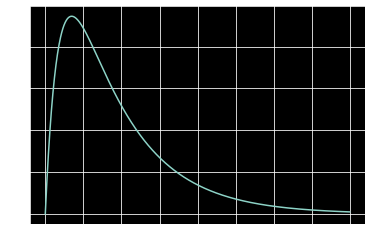

In [3]:
#Neuron Parameters for LIF model
C = 300 
gL = 30
EL = -70
VT = 20 
dt = 0.1 #timestep
# Obtaining kernel
kerlen = 80
tau1 = 15
tau2 = 3.75
ker,Nk = currentKernal(dt,tau1,tau2,kerlen)
plt.plot(ker)
plt.grid()

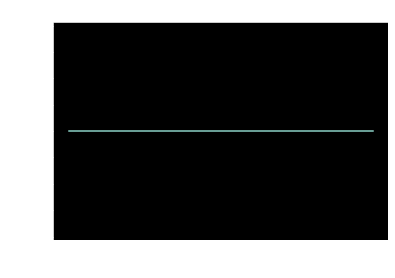

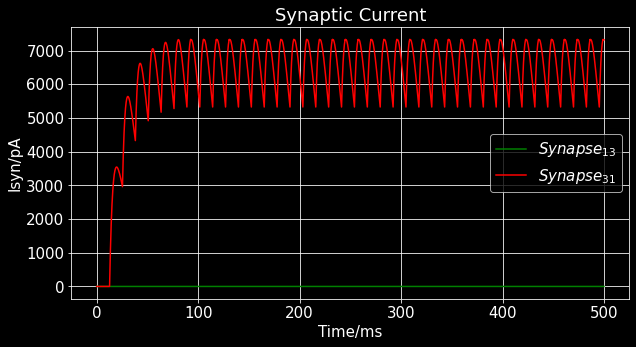

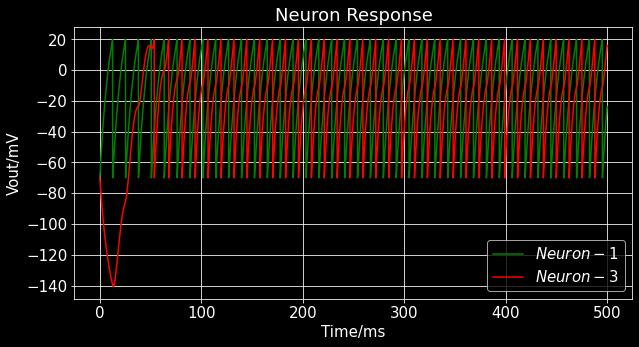

In [4]:
#Testing neurons 1 and 2 of the positive comparator 
alpha = 3750
#pA
beta = 350 #pA/K
T = 20*np.ones(5000) #Can change the temperature tested here

Iinp1 = currentInputGen(T,20,alpha,beta) #Set Threshold Temperature to 20C
plt.plot(Iinp1[:100])
plt.xlabel('Time - 0.1s/timestep')
plt.ylabel("Neuron-1 Current Input/pA")
plt.title("Simple Demo")
plt.show()

Time = 10000 #Total time of simulation
iter=np.int_(Time/dt) #Number of timesteps
Numneurons = 2
I1 = np.vstack((Iinp1,np.zeros((Numneurons-1,np.shape(Iinp1)[0]))))

I_bias = np.zeros((2,5000)) #so it's 2 by 5000
I_bias[1] = -2900
t = dt*(np.arange(len(I1[1])))

W1=[[0,0],
   [7500,0]] #weight matrix 

Vmem1,Isyn1 = simulateLIF(dt,I1,C,gL,EL,VT,W1,ker,Nk,I_bias) 
#Plotting Synaptic Curents
plotter(t,Isyn1[0,0:np.shape(I1)[1]],
        "Synaptic Current",
        "Isyn/pA",
        '$Synapse_{13}$',
        Isyn1[1,0:np.shape(I1)[1]],
        '$Synapse_{31}$',True)
#Plotting Neuron Response
plotter(t,Vmem1[0,0:np.shape(I1)[1]],
        "Neuron Response",
        "Vout/mV",
        '$Neuron-1$',
        Vmem1[1,0:np.shape(I1)[1]],
        '$Neuron-3$',True)

spike_count = np.shape(np.where(Vmem1[1,0:np.shape(I1)[1]] == VT))[1]


# print(I1)
# print(Isyn1[1,0:np.shape(I1)[1]])
# print(I_bias)
# print(spike_count)

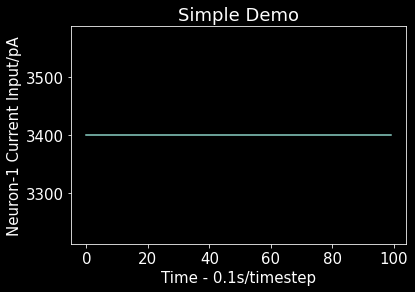

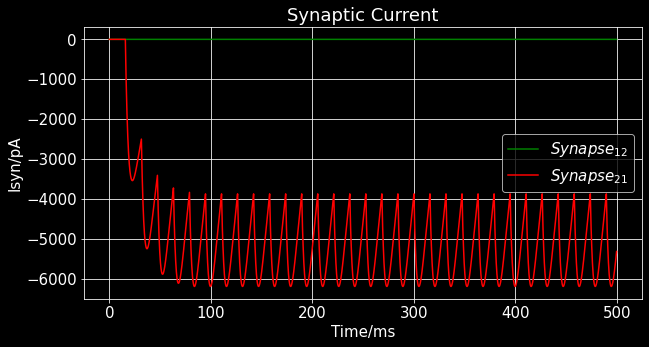

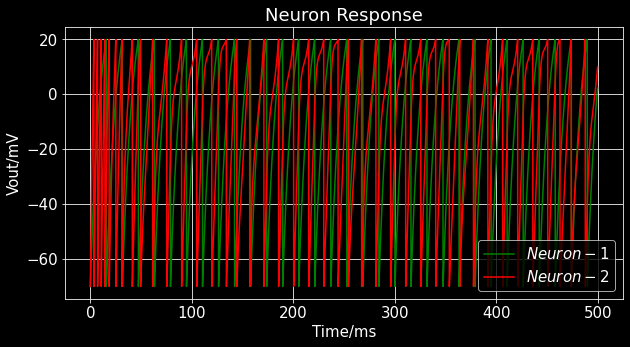

In [5]:
#Testing neurons 1 and 2 of the negative comparator 
alpha = 3750
#pA
beta = 350 #pA/K
T = 19*np.ones(5000) #Change the temperature tested here

Iinp1 = currentInputGen(T,20,alpha,beta) #Set Threshold Temperature to 20C
plt.plot(Iinp1[:100])
plt.xlabel('Time - 0.1s/timestep')
plt.ylabel("Neuron-1 Current Input/pA")
plt.title("Simple Demo")
plt.show()

Time = 10000 #Total time of simulation
iter=np.int_(Time/dt) #Number of timesteps
Numneurons = 2
I1 = np.vstack((Iinp1,np.zeros((Numneurons-1,np.shape(Iinp1)[0]))))

I_bias = np.zeros((2,5000)) 
I_bias[1] = 9000

t = dt*(np.arange(len(I1[1])))

W1=[[0,0],
   [-7500,0]] #weight matrix

Vmem1,Isyn1 = simulateLIF(dt,I1,C,gL,EL,VT,W1,ker,Nk,I_bias)  
#Plotting Synaptic Curents
plotter(t,Isyn1[0,0:np.shape(I1)[1]],
        "Synaptic Current",
        "Isyn/pA",
        '$Synapse_{12}$',
        Isyn1[1,0:np.shape(I1)[1]],
        '$Synapse_{21}$',True)
#Plotting Neuron Response
plotter(t,Vmem1[0,0:np.shape(I1)[1]],
        "Neuron Response",
        "Vout/mV",
        '$Neuron-1$',
        Vmem1[1,0:np.shape(I1)[1]],
        '$Neuron-2$',True)

spike_count = np.shape(np.where(Vmem1[1,0:np.shape(I1)[1]] == VT))[1]


# print(I1)
# print(Isyn1[1,0:np.shape(I1)[1]])
# print(I_bias)
# print(spike_count)

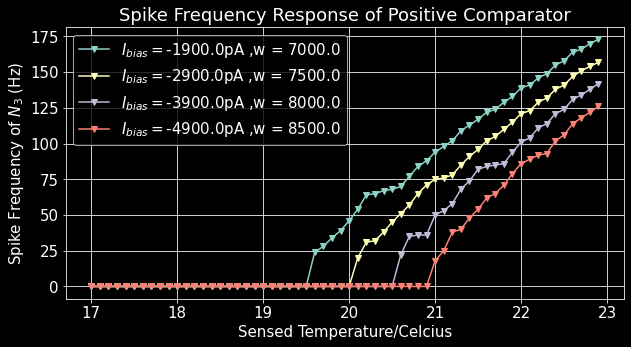

array([4415., 4415., 4415., ..., 4415., 4415., 4415.])

In [6]:
#positive comparator multiple values

T = 10000 #Total time of simulation
Numneurons = 2
dt = 0.1

#Setting up bias currents for simulation
I_bias = np.zeros((4,2,T))
I_bias[0][1] = -1900
I_bias[1][1] = -2900
I_bias[2][1] = -3900
I_bias[3][1] = -4900
#Setting up weights for simulation
comparator_weights = np.ones((4,2,2))
comparator_weights[0] = [[0,0],
                        [7000,0]]
comparator_weights[1] = [[0,0],
                        [7500,0]]
comparator_weights[2] = [[0,0],
                        [8000.0,0]]
comparator_weights[3] = [[0,0],
                        [8500,0]]
temperatures = np.arange(17,23,0.1)



frequencies = []
for i in range(len(comparator_weights)):
    spike_frequency = []
    for t in range(len(temperatures)):
        alpha = 3750 #pA
        beta = 350 #pA/K

        Temp = temperatures[t]*np.ones(T)
        Iinp = currentInputGen(Temp,21,alpha,beta) #Set Threshold Temperature to 20C
        iter=np.int_(T/dt) #Number of timesteps
        I = np.vstack((Iinp,np.zeros((Numneurons-1,np.shape(Iinp)[0]))))
        t = dt*(np.arange(len(I[1])))
        Vmem1,Isyn1 = simulateLIF(dt,I,C,gL,EL,VT,comparator_weights[i],ker,Nk,I_bias[i])#Simulate
        # Estimating Spike Count and Frequency
        spike_count = np.shape(np.where(Vmem1[1,0:np.shape(I)[1]] == VT))[1]
        spike_frequency.append(spike_count)
    frequencies.append(spike_frequency)

#Plotting 
plt.style.use('dark_background')
plt.figure(figsize=(10,5)) #Customisable size
plt.rcParams.update({'font.size': 15})
plt.grid(True)
for i in range(len(frequencies)):
    plt.plot(temperatures,frequencies[i], label = "$I_{bias} = $" + str(I_bias[i][1][0]) + "pA"
                + " ,w = " + str(comparator_weights[i][1][0]), marker = "v")
plt.legend()
plt.title("Spike Frequency Response of Positive Comparator")
plt.xlabel("Sensed Temperature/Celcius")
plt.ylabel("Spike Frequency of $N_3$ (Hz)")
plt.show()

Iinp 

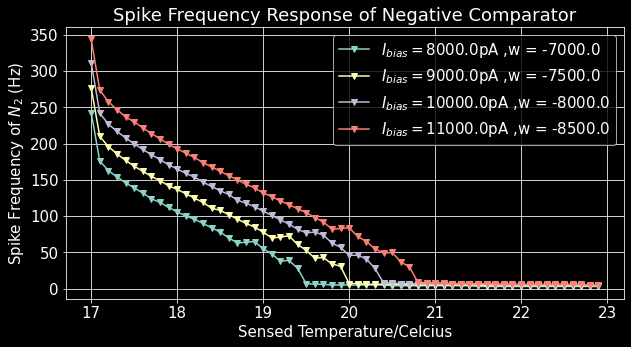

In [7]:
#negative comparator multiple values 

T = 10000 #Total time of simulation
Numneurons = 2
dt = 0.1

#Setting up bias currents for simulation
I_bias = np.zeros((4,2,T))



I_bias[0][1] = 8000
I_bias[1][1] = 9000
I_bias[2][1] = 10000
I_bias[3][1] = 11000

#Setting up weights for simulation
comparator_weights = np.ones((4,2,2))
comparator_weights[0] = [[0,0],
                        [-7000,0]]
comparator_weights[1] = [[0,0],
                        [-7500,0]]
comparator_weights[2] = [[0,0],
                        [-8000,0]]
comparator_weights[3] = [[0,0],
                        [-8500,0]]

temperatures = np.arange(17,23,0.1)


frequencies = []
for i in range(len(comparator_weights)):
    spike_frequency = []
    for t in range(len(temperatures)):
        alpha = 3750 #pA
        beta = 350 #pA/K
        Temp = temperatures[t]*np.ones(T)
        Iinp = currentInputGen(Temp,20,alpha,beta) #Set Threshold Temperature to 20C
        iter=np.int_(T/dt) #Number of timesteps
        I = np.vstack((Iinp,np.zeros((Numneurons-1,np.shape(Iinp)[0]))))
        t = dt*(np.arange(len(I[1])))
        Vmem1,Isyn1 = simulateLIF(dt,I,C,gL,EL,VT,comparator_weights[i],ker,Nk,I_bias[i])#Simulate
        # Estimating Spike Count and Frequency
        spike_count = np.shape(np.where(Vmem1[1,0:np.shape(I)[1]] == VT))[1]
        spike_frequency.append(spike_count)
    frequencies.append(spike_frequency)

#Plotting 
plt.style.use('dark_background')
plt.figure(figsize=(10,5)) #Customisable size
plt.rcParams.update({'font.size': 15})
plt.grid(True)
for i in range(len(frequencies)):
    plt.plot(temperatures,frequencies[i], label = "$I_{bias} = $" + str(I_bias[i][1][0]) + "pA"
                + " ,w = " + str(comparator_weights[i][1][0]), marker = "v")
plt.legend()
plt.title("Spike Frequency Response of Negative Comparator")
plt.xlabel("Sensed Temperature/Celcius")
plt.ylabel("Spike Frequency of $N_2$ (Hz)")
plt.show()